In [0]:
!pip -q install numpy keras tqdm matplotlib joblib

# Assignment 3.3

Suraj Iyer (866094)  
Sander Boelders (0916836)


# Image Caption Retrieval Model

### 1. Data preprocessing

We will use Microsoft COCO (Common Objects in Context) data set to train our "Image Caption Retrieval Model". This data set consists of pretrained 10-crop VGG19 features (Neural codes) and its corresponding text caption. 


In [0]:
from __future__ import print_function

import os
import sys
import numpy as np
np.random.seed(13)
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm
import re
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from IPython.display import clear_output
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

DATA_PATH = 'data'
EMBEDDING_PATH = 'embeddings'
MODEL_PATH = 'models'

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

def download_from_gdrive(file_name, file_id):
  """Download a file from google drive.
  
  Attributes:
    file_name: string
      Name to save the file with.
    
    file_id: string
      A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
  """

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = open(file_name, "wb")
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  current_progress = -1

  while done is False:
    status, done = downloader.next_chunk()
    if status:
      if current_progress != status.progress():
        current_progress = status.progress()
        clear_output(wait=True)
        print("Download %d%%." % int(current_progress * 100))

You will need to create above directories and locate data set provided in directory 'data'

In [4]:
# !wget -nc "https://storage.googleapis.com/trl_data/img_cap_coco.zip"
download_from_gdrive('img_cap_coco.zip', '1Wyite3OCnTOdD6WbuTaek9qDiP4BvzA2')
!wget -nc "http://images.cocodataset.org/zips/val2014.zip"
!mkdir -p data
!mkdir -p embeddings
!mkdir -p models
!unzip -n -qq val2014.zip -d data
!unzip -n -qq img_cap_coco.zip
!ls

Download 100%.
File ‘val2014.zip’ already there; not retrieving.

replace data/val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace data/img_cap_coco/test_data.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
data	 embeddings    img_cap_coco.zip  models.zip
datalab  glove.6B.zip  models		 val2014.zip


#### Reading pairs of image (VGG19 features) - caption data

In [0]:
# DO NOT CHANGE BELOW CODE

import collections

np_train_data = np.load(os.path.join(DATA_PATH, 'img_cap_coco', 'train_data.npy'))
np_val_data = np.load(os.path.join(DATA_PATH, 'img_cap_coco', 'val_data.npy'))

if 'img_urls' in np_train_data.item().keys():
    train_data = np_train_data.item()
else:
    train_data = collections.OrderedDict()
    for i in range(len(np_train_data.item())):
        cap =  np_train_data.item()['caps']
        img =  np_train_data.item()['ims']
        train_data['caps'] = cap
        train_data['ims'] = img

if 'img_urls' in np_val_data.item().keys():
    val_data = np_val_data.item()
else:
    val_data = collections.OrderedDict()
    for i in range(len(np_val_data.item())):
        cap =  np_val_data.item()['caps']
        img =  np_val_data.item()['ims']
        val_data['caps'] = cap
        val_data['ims'] = img

In [8]:
print(len(train_data['ims']), len(train_data['caps']))
print(len(val_data['ims']), len(val_data['caps']))

10000 50000
5000 25000


In [0]:
# example of caption
print(train_data['caps'][0])

b'a woman wearing a net on her head cutting a cake'


In [0]:
# example of pre-computed VGG19 features
val_data['ims'][0]

array([0.00109166, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

#### Reading caption and information about its corresponding raw images from Microsoft COCO website

In [0]:
# DO NOT CHANGE BELOW CODE
# use them for your own additional preprocessing step
# to map precomputed features and location of raw images 

import json

with open(os.path.join(DATA_PATH, 'img_cap_coco', 'instances_val2014.json')) as json_file:
    coco_instances_val = json.load(json_file)
    
with open(os.path.join(DATA_PATH, 'img_cap_coco', 'captions_val2014.json')) as json_file:
    coco_caption_val = json.load(json_file)

#### Additional preprocessing

In [0]:
# create your own function to map pairs of precomputed features and filepath of raw images
# this will be used later for visualization part
# simple approach: based on matched text caption (see json file)

# YOUR CODE HERE
from joblib import Parallel, delayed
import multiprocessing
from math import ceil

def pad_zeros(id):
    id = str(id)
    return '0'*(12-len(id)) + id

def get_image_url(data, i):
    try:
        image_id = next(ann['image_id'] for ann in coco_caption_val['annotations'] 
                        for cap in data['caps'][i*5:(i+1)*5] 
                        if cap.decode().lower() in ann['caption'].lower())
    except Exception:
        image_id = next(ann['image_id'] for ann in coco_caption_val['annotations'] 
                        for cap in data['caps'][i*5:(i+1)*5] 
                        if re.sub('\W+','', cap.decode().lower()) in re.sub('\W+','', ann['caption'].lower()))
    return 'COCO_val2014_{}.jpg'.format(pad_zeros(image_id))

def get_image_urls(data, n_iters=10, n_skips=0):
    n_images = len(data['ims'])
    batch_size = ceil(n_images/n_iters)
    end = min(n_images, n_skips * batch_size)
    num_cores = multiprocessing.cpu_count()
    
    with Parallel(n_jobs=num_cores) as parallel:
        for _ in tqdm(range(n_skips, n_iters), initial=n_skips):
            start = end
            end = min(n_images, start + batch_size)
            result = parallel(delayed(get_image_url)(data, i) for i in range(start, end))
            data['img_urls'][start:end] = result
    
    return data

In [0]:
%env JOBLIB_TEMP_FOLDER=/tmp

train_data['img_urls'] = [0]*len(train_data['ims'])
train_data = get_image_urls(train_data)
np.save(os.path.join(DATA_PATH, 'img_cap_coco', 'train_data.npy'), train_data)

val_data['img_urls'] = [0]*len(val_data['ims'])
val_data = get_image_urls(val_data, n_skips=5)
np.save(os.path.join(DATA_PATH, 'img_cap_coco', 'val_data.npy'), val_data)

In [0]:
# Zip up modified img_cap_coco files
!rm -f img_cap_coco.zip
!cd data; zip -r img_cap_coco.zip img_cap_coco; cd ./;

file_metadata = {
  'name': 'img_cap_coco.zip',
  'mimeType': 'application/zip'
}
media = MediaFileUpload('img_cap_coco.zip', 
                        mimetype='application/zip',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

  adding: data/img_cap_coco/ (stored 0%)
  adding: data/img_cap_coco/test_data.npy (deflated 48%)
  adding: data/img_cap_coco/captions_val2014.json (deflated 80%)
  adding: data/img_cap_coco/instances_val2014.json (deflated 68%)
  adding: data/img_cap_coco/train_data.npy (deflated 48%)
  adding: data/img_cap_coco/val_data.npy (deflated 48%)
File ID: 1Wyite3OCnTOdD6WbuTaek9qDiP4BvzA2


#### Build vocabulary index 

In [11]:
# DO NOT CHANGE BELOW CODE

def build_dictionary(text):

    wordcount = OrderedDict()
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1
    words = list(wordcount.keys())
    freqs = list(wordcount.values())
    sorted_idx = np.argsort(freqs)[::-1]
    
    worddict = OrderedDict()
    worddict['<pad>'] = 0
    worddict['<unk>'] = 1
    for idx, sidx in enumerate(sorted_idx):
        worddict[words[sidx]] = idx+2  # 0: <pad>, 1: <unk>
    

    return worddict

# use the resulting vocabulary index as your look up dictionary
# to transform raw text into integer sequences

all_captions = []
all_captions = train_data['caps'] + val_data['caps']

# decode bytes to string format
caps = []
for w in all_captions:
    caps.append(w.decode())
    
words_indices = build_dictionary(caps)
print ('Dictionary size: ' + str(len(words_indices)))
indices_words = dict((v,k) for (k,v) in words_indices.items())

def tokenize(text):
    text = text.lower()
    text = "".join(c for c in text if c != '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    text = [words_indices[w] for w in text.split()]
    return text

Dictionary size: 11473


### 2. Image - Caption Retrieval Model

In [0]:
# load models from file if it exists
download_from_gdrive('models.zip', '12ARAP7HnGigd3TEBikZiFn6-GO26NhA5')
!unzip -n -qq models.zip
training_model = load_model(os.path.join(MODEL_PATH, 'image_caption_model.h5'))
caption_model = load_model(os.path.join(MODEL_PATH, 'caption_model.h5'))
image_model = load_model(os.path.join(MODEL_PATH, 'image_model.h5'))

### Image model

In [15]:
# YOUR CODE HERE
encode_dim = 1024
image_model = Sequential()
image_model.add(Dense(encode_dim, input_shape=(4096,)))
image_model.summary()

image_input = Input((4096,))
encoded_image = image_model(image_input)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4195328   
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


### Caption model

In [10]:
# YOUR CODE HERE
!wget -nc "http://nlp.stanford.edu/data/glove.6B.zip"
!rm -rf data/glove.6B
!mkdir data/glove.6B
!unzip -n -qq glove.6B.zip -d data/glove.6B
!ls data/glove.6B

--2018-04-10 16:29:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-04-10 16:29:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         37%[======>             ] 311.34M  7.02MB/s    eta 50s    

glove.6B.zip        100%[===================>] 822.24M  8.47MB/s    in 1m 49s  

2018-04-10 16:31:05 (7.57 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [16]:
from keras.layers.recurrent import GRU

# function to load pretrained embedding
def load_embedding(vocab, dimension, filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    embedding = np.zeros((max(vocab.values()) + 1, dimension), dtype=np.float32)
    seen = set()
    with open(filename) as fp:
        for line in fp:
            tokens = line.strip().split(' ')
            if len(tokens) == dimension + 1:
                word = tokens[0]
                if word in vocab:
                    embedding[vocab[word]] = [float(x) for x in tokens[1:]]
                    seen.add(word)
                    if len(seen) == len(vocab):
                        break
    return embedding

vocab = words_indices
weights = load_embedding(vocab, 100, os.path.join(DATA_PATH,'glove.6B', 'glove.6B.100d.txt'))

maxlen = 50
positive_input = Input((maxlen, ))
negative_input = Input((maxlen, ))

# For embedding layer, initialize with pretrained word embedding (GloVe)
embedding_layer = Embedding(len(vocab), 100, weights=[weights], input_length=maxlen, 
                            trainable=False, name='word_embedding')
caption_model = Sequential()
caption_model.add(embedding_layer)
caption_model.add(GRU(encode_dim))
caption_model.summary()

encoded_p = caption_model(positive_input)
encoded_n = caption_model(negative_input)

loading embeddings from "data/glove.6B/glove.6B.100d.txt"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding (Embedding)   (None, 50, 100)           1147300   
_________________________________________________________________
gru_1 (GRU)                  (None, 1024)              3456000   
Total params: 4,603,300
Trainable params: 3,456,000
Non-trainable params: 1,147,300
_________________________________________________________________


### Join model

In [0]:
# YOUR CODE HERE
from keras.layers import dot, concatenate

# layer for computing dot product between tensors
positive_ex = dot([encoded_image, encoded_p], axes=-1)
negative_ex = dot([encoded_image, encoded_n], axes=-1)
output = concatenate([positive_ex, negative_ex])

### Main model for training stage

In [18]:
# YOUR CODE HERE

# define your model input and output
print ("loading the training model")
training_model = Model(inputs=[image_input, positive_input, negative_input], 
                       outputs=output)

loading the training model


### Retrieval model

In [15]:
# # YOUR CODE HERE

# # define your model input and output

# print ("loading sub-models for retrieving Neural codes")
# caption_model = Model(inputs=positive_input, outputs=encoded_p)
# image_model = Model(inputs=image_input, outputs=encoded_image)

loading sub-models for retrieving Neural codes


### Loss function

We define our loss function as a loss for maximizing the margin between a positive and
negative example.  If we call $p_i$ the score of the positive pair of the $i$-th example, and $n_i$ the score of the negative pair of that example, the loss is:

\begin{equation*}
loss = \sum_i{max(0, 1 -p_i + n_i)}
\end{equation*}

In [0]:
from keras import backend as K

def max_margin_loss(y_true, y_pred):
    
    # YOUR CODE HERE
    loss_ = K.sum(K.maximum(0., 1 - y_pred[:,0] + y_pred[:,1]))
    
    return loss_

#### Accuracy metric for max-margin loss
How many times did the positive pair effectively get a higher value than the negative pair?

In [0]:
# YOUR CODE HERE
def accuracy(y_true, y_pred):
    
    # YOUR CODE HERE
    accuracy_ = K.mean(y_pred[:,0] > y_pred[:,1])
    
    return accuracy_

### Compile model

In [21]:
# DO NOT CHANGE BELOW CODE
print ("compiling the training model")
training_model.compile(optimizer='adam', loss=max_margin_loss, metrics=[accuracy])
training_model.summary()

# if weights file exists, load model weights
if os.path.isfile(os.path.join(MODEL_PATH, 'weights_image_caption.hdf5')):
    print("Loading pre-trained weights...")
    training_model.load_weights(os.path.join(MODEL_PATH, 'weights_image_caption.hdf5'))

compiling the training model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         4195328     input_1[0][0]                    
________________________________________________________________________________

### 3. Data preparation for training the model

* adjust the length of captions into fixed maximum length (50 words)
* sampling caption for each image, while shuffling the image data
* encode captions into integer format based on look-up vocabulary index

In [0]:
# sampling one caption per image
# return image_ids, caption_ids

def sampling_img_cap(data):
    
    # YOUR CODE HERE
    n = len(data['ims'])
    image_ids = np.random.choice(n, size=n, replace=False)
    caption_ids = [i*5 + np.random.choice(5) for i in image_ids]
    
    return image_ids, caption_ids

In [0]:
# transform raw text caption into integer sequences of fixed maximum length
from keras.preprocessing.sequence import pad_sequences

def prepare_caption(caption_ids, caption_data, maxlen=50):

    # YOUR CODE HERE
    texts = [caption_data[i] for i in caption_ids]
    sequences = [tokenize(txt) for txt in texts]
    caption_seqs = pad_sequences(sequences, maxlen=maxlen)
      
    return caption_seqs

In [0]:
# DO NOT CHANGE BELOW CODE

train_caps = []
for cap in train_data['caps']:
    train_caps.append(cap.decode())

val_caps = []
for cap in val_data['caps']:
    val_caps.append(cap.decode())

In [0]:
# DO NOT CHANGE BELOW CODE

train_image_ids, train_caption_ids = sampling_img_cap(train_data)
val_image_ids, val_caption_ids = sampling_img_cap(val_data)

x_caption = prepare_caption(train_caption_ids, train_caps)
x_image = train_data['ims'][np.array(train_image_ids)]

x_val_caption = prepare_caption(val_caption_ids, val_caps)
x_val_image = val_data['ims'][np.array(val_image_ids)]

### 4. Create noise set for negative examples of image-fake caption and dummy output

Notice that we do not have real output with labels for training the model. Keras architecture expects labels, so we need to create dummy output -- which is numpy array of zeros. This dummy labels or output is never used since we compute loss function based on margin between positive examples (image-real caption) and negative examples (image-fake caption).

In [0]:
# YOUR CODE HERE

train_noise = np.copy(x_caption)
val_noise = np.copy(x_val_caption)

y_train_labels = [(0., 0.) for _ in train_image_ids]
y_val_labels = [(0., 0.) for _ in val_image_ids]

### 5. Training model

In [0]:
# YOUR CODE HERE

X_train = lambda noise: [x_image, x_caption, noise]
Y_train = np.array(y_train_labels)
X_valid = lambda noise: [x_val_image, x_val_caption, noise]
Y_valid = np.array(y_val_labels)

In [28]:
# YOUR CODE HERE

# fit the model on training and validation set
for _ in range(10):
    np.random.shuffle(train_noise)
    np.random.shuffle(val_noise)
    training_model.fit(X_train(train_noise), Y_train, epochs=1,
                       validation_data=(X_valid(val_noise), Y_valid))

Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 90s 9ms/step - loss: 6.8065 - accuracy: 0.9123 - val_loss: 4.2932 - val_accuracy: 0.9456
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 4928/10000 [=============>................] - ETA: 39s - loss: 3.7004 - accuracy: 0.9547

10000/10000 [==============================] - 90s 9ms/step - loss: 3.4505 - accuracy: 0.9591 - val_loss: 4.3174 - val_accuracy: 0.9472
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 9632/10000 [===========================>..] - ETA: 2s - loss: 2.8085 - accuracy: 0.9657

10000/10000 [==============================] - 89s 9ms/step - loss: 2.7828 - accuracy: 0.9657 - val_loss: 2.7741 - val_accuracy: 0.9662
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 89s 9ms/step - loss: 2.3773 - accuracy: 0.9702 - val_loss: 3.3055 - val_accuracy: 0.9636
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
  608/10000 [>.............................] - ETA: 1:12 - loss: 2.2472 - accuracy: 0.9720

10000/10000 [==============================] - 89s 9ms/step - loss: 2.3940 - accuracy: 0.9717 - val_loss: 2.9786 - val_accuracy: 0.9616
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 8256/10000 [=======================>......] - ETA: 13s - loss: 2.2628 - accuracy: 0.9727

10000/10000 [==============================] - 89s 9ms/step - loss: 2.2428 - accuracy: 0.9732 - val_loss: 2.3745 - val_accuracy: 0.9716
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 89s 9ms/step - loss: 1.8659 - accuracy: 0.9781 - val_loss: 3.3842 - val_accuracy: 0.9624
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
  352/10000 [>.............................] - ETA: 1:14 - loss: 1.6822 - accuracy: 0.9744

10000/10000 [==============================] - 89s 9ms/step - loss: 1.8951 - accuracy: 0.9775 - val_loss: 3.2253 - val_accuracy: 0.9616
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 8160/10000 [=======================>......] - ETA: 14s - loss: 1.6272 - accuracy: 0.9800

10000/10000 [==============================] - 89s 9ms/step - loss: 1.6274 - accuracy: 0.9805 - val_loss: 2.7428 - val_accuracy: 0.9672
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 89s 9ms/step - loss: 1.5653 - accuracy: 0.9819 - val_loss: 3.2026 - val_accuracy: 0.9644


#### Storing models and weight parameters

In [0]:
# DO NOT CHANGE BELOW CODE

# Save model
training_model.save(os.path.join(MODEL_PATH,'image_caption_model.h5'))
# Save weight parameters
training_model.save_weights(os.path.join(MODEL_PATH, 'weights_image_caption.hdf5'))

# Save model for encoding caption and image
caption_model.save(os.path.join(MODEL_PATH,'caption_model.h5'))
image_model.save(os.path.join(MODEL_PATH,'image_model.h5'))

In [30]:
# Zip up models and weights files
!rm -f models.zip
!zip -r models.zip models

file_metadata = {
  'name': 'models.zip',
  'mimeType': 'application/zip'
}
media = MediaFileUpload('models.zip', 
                        mimetype='application/zip',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

  adding: models/ (stored 0%)
  adding: models/caption_model.h5 (deflated 9%)
  adding: models/image_caption_model.h5 (deflated 9%)
  adding: models/image_model.h5 (deflated 7%)
  adding: models/weights_image_caption.hdf5 (deflated 8%)
File ID: 12ARAP7HnGigd3TEBikZiFn6-GO26NhA5


### 6. Feature extraction (Neural codes)

In [0]:
# YOUR CODE HERE

# Use caption_model and image_model to produce "Neural codes" 
# for both image and caption from validation set
image_features = image_model.predict(x_val_image)
caption_features = caption_model.predict(x_val_caption)

### 7. Caption Retrieval

#### Display original image as query and its ground truth caption

[b'a person and a kid on top of a refrigerator'
 b'the man looks up at a small child sitting on a refrigerator'
 b'a baby is sitting on top of a fridge while a man looks at her'
 b'a man standing in front of a metallic refrigerator freezer with a baby on top of it'
 b'a man standing by a refrigerator with a baby sitting on top of it']


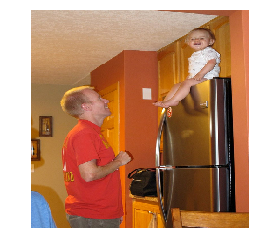

In [37]:
# Test matched captions
def load_img(file_path):
    plt.figure()
    plt.axis('off')
    img = image.load_img(file_path, target_size=(224,224))
    imgplt = plt.imshow(img)

def load_example(data, i=0):
    load_img(os.path.join(DATA_PATH, 'val2014', data['img_urls'][i]))
    print(np.array(data['caps'][i*5:(i+1)*5]))

load_example(val_data, 4998)

kitchen area with an open refrigerator and freezer


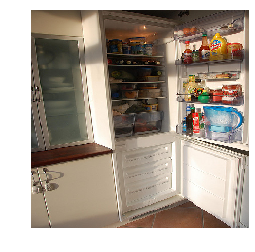

In [34]:
# YOUR CODE HERE

# choose one image_id from validation set
# use this id to get filepath of image
choice = np.random.choice(len(val_image_ids), 1)[0]
img_id = val_image_ids[choice]
filepath_image = os.path.join(DATA_PATH, 'val2014', val_data['img_urls'][img_id])

# display original caption
cap_id = val_caption_ids[choice]
original_caption = val_caps[cap_id]
print(original_caption)

# DO NOT CHANGE BELOW CODE
img = image.load_img(filepath_image, target_size=(224,224))
plt.imshow(img)
plt.axis("off")
plt.show()

In [0]:
# function to retrieve caption, given an image query

def get_caption(image_filename, n=10):
    # find id of vgg19 features corresponding to given filename
    _, file_name = os.path.split(image_filename)
    img_id = next(i for i, _ in enumerate(val_data['img_urls']) if _ == file_name)
    
    # get image neural codes for input image features
    img = image_model.predict(val_data['ims'][img_id].reshape(1, -1))
    
    # calculate the similarity scores between image features and 
    # all captions features (by dot product)
    similarity_scores = np.dot(caption_features, img.T).flatten()
    
    # Sort scores and get top n scoring captions
    cap_ids = np.argsort(similarity_scores)[::-1][:n]
    similarity_scores = similarity_scores[cap_ids]
    caps = np.array(val_caps)[np.array(val_caption_ids)[cap_ids]]
    
    # Print the scores and the corresponding captions
    print('Scores \t\t Caption')
    for i in range(len(caps)):
        print(similarity_scores[i], '\t', caps[i])

In [36]:
# DO NOT CHANGE BELOW CODE
get_caption(filepath_image)

Scores 		 Caption
3.3069987 	 this kitchen is mostly white and beige in color
2.7600806 	 a photo of a chinese restaurants stocked supplies
2.4591231 	 a refrigerator that has many different magnets on it
2.0430856 	 a fridge in an empty kitchen with nothing on the shelves
1.9339924 	 the grillmaster is cooking all kinds of meat
1.5442013 	 a kitchen with a stove a refrigerator and some cupbords
1.4699397 	 a kitchen contains a large refrigerator with a freezer below it
1.4604053 	 a man looking into a refrigerator door for ingredients
1.4307307 	 an image of a kitchen setting with white appliances
1.4003208 	 a metallic refrigerator freezer next to a wooden counter


Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

In the example case above, the first caption is surprisngly accurate though it is not the same as the original caption. The second caption at first seems completely inaccurate but actually detects the stocked supplies in the refrigerator correctly. The rest of the captions are not accurate enough. Many of them detect the following keywords correctly: refrigerator, freezer, kitchen, cupboards, wooden counter, shelves. But the remaining words do not describe the scene. The main reason for this is because all these captions contain keywords that partly describe the scene but not completely. Moreover the network is not trained to generate a novel caption from scratch but rather pick one from a predefined list.

### 8. Image Retrieval

In [0]:
# given text query, display retrieved image, similarity score, and its original caption 

def search_image(text_caption, n=10):
    # Get caption features of input caption
    text_caption = tokenize(text_caption)
    sequence = pad_sequences([text_caption], maxlen=maxlen)
    cap = caption_model.predict(sequence)
    
    # calculate the similarity scores between caption features and 
    # all images features (by dot product)
    similarity_scores = np.dot(image_features, cap.T).flatten()
    
    # Sort scores and get top n scoring images
    img_ids = np.argsort(similarity_scores)[::-1][:n]
    similarity_scores = similarity_scores[img_ids]
    imgs = np.array(val_data['img_urls'])[np.array(val_image_ids)[img_ids]]
    
    # plot these images
    plt.figure(figsize=(32, 32))
    for i, filepath in enumerate(imgs):
        plt.subplot(1, n, i+1)
        plt.axis('off')
        img = image.load_img(os.path.join(DATA_PATH, 'val2014', filepath), 
                             target_size=(300, 300))
        plt.imshow(img)
    plt.show()

Consider to use the following settings for image retrieval task.

* use real caption that is available in validation set as a query.
* use part of caption as query. For instance, instead of use the whole text sentence of the
caption, you may consider to use key phrase or combination of words that is included in
corresponding caption.

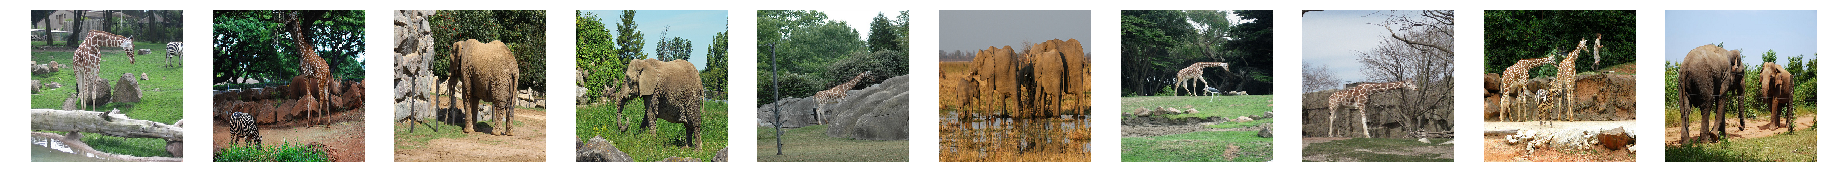

In [57]:
# Example of text query 
# text = 'two giraffes standing near trees'

# YOUR QUERY-1
text1 = 'two giraffes standing near trees'

# DO NOT CHANGE BELOW CODE
search_image(text1)

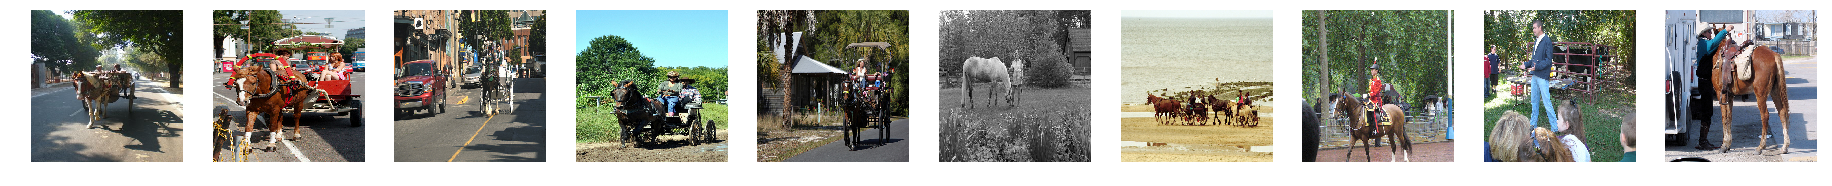

In [58]:
# YOUR QUERY-2
text2 = 'a man walking with sheeps'

# DO NOT CHANGE BELOW CODE
search_image(text2)

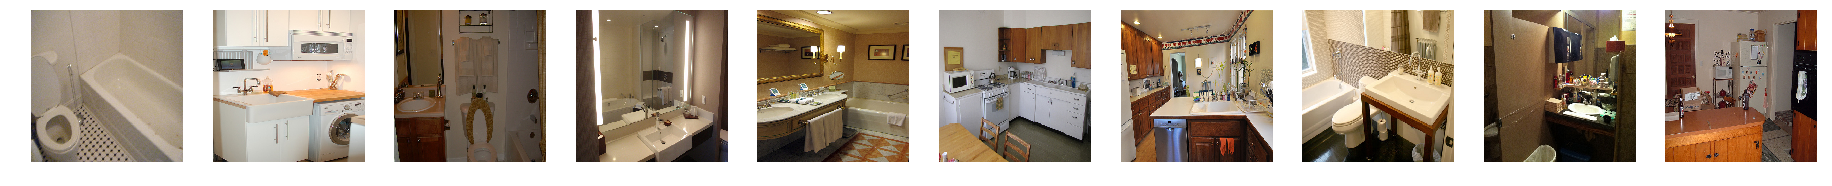

In [60]:
# YOUR QUERY-2
text3 = 'this kitchen is mostly white and beige in color'

# DO NOT CHANGE BELOW CODE
search_image(text3)

Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

In the first case, we see that the network has understood what giraffes are but not that we are looking for two of them. We suppose that there is not sufficient number of training examples to differentiate between singular and plural results. Secondly the network has not learnt to differentiate between giraffes and elephants quite well which probably can be rectified with more training.

In the second case, all the returned images are completely innaccurate because they contain horses when we are actually looking for sheeps. We suppose that the learnt representation for horses is quite similar for sheeps. Another reason could be that we are also looking for the keywords: 'man' and 'walking' which may be affecting the resulting representation more strongly than 'sheeps'.

In the third case, the network has understood white and beige colors but cannot differentiate between kitchen and bathroom quite well. This could be due to the similarity in the structure of both rooms, e.g.: walls, lighting etc.

Assuming the VGG19 features for the images and the Glove embeddings for each word are good enough, the main reason the retrieval does not work well is because the thought vectors of the captions and the images are not close enough in the embeddings space which means it requires more training. But the model already achieves 98% and 96% training and validation accuracies respectively. There are two possibilites to improve the model:

* We do not make use of all the captions for each of the images. We can increase our training samples by using all the captions data and modifying our loss function to account for this change.
* Our definition of accuracy is the number of times the positive pairs got ranked higher than the negative pairs but our negative pairs are picked randomly, therefore the accuracy measure might be misleading. The capacity to change the model reasonably lies in the 4% validation samples that did not get the correct matching. Our negative sampling method could be improved such that it always finds difficult negative examples.